# Jack Henry Data Engineering Challenge: Lending Club Analysis

**Dataset**: Lending Club Loan Data (2007-2015)

## Executive Summary
This notebook analyzes Lending Club loan data to provide insights on default patterns by loan grade. Key findings:
- Loan grades effectively stratify default risk (A: ~5% vs G: ~30%)
- Portfolio concentration in mid-tier grades (C-E) balances risk and volume
- High-risk grades (F-G) may require enhanced risk controls

## Contents
1. Data Loading & Validation
2. Data Cleaning & Preparation
3. Exploratory Data Analysis
4. Grade-Level Analysis
5. Risk-Return Visualization
6. Business Insights & Recommendations

## 1. Setup & Data Loading

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

from data_loader import load_lending_club_data, validate_required_columns, get_basic_info
from data_cleaner import clean_lending_club_data, get_cleaning_summary, validate_cleaned_data
from analyzer import calculate_grade_metrics, calculate_portfolio_metrics, analyze_risk_return_relationship
from visualizer import plot_default_rate_by_grade, plot_risk_return_analysis, create_executive_dashboard

# Create visualizations folder if it's not existing
os.makedirs('../outputs/visualizations', exist_ok=True)

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Environment setup complete!")
print(f"Working directory: {Path.cwd()}")


Environment setup complete!
Working directory: /Users/shivanipagadala/Documents/Lending_club_assignment/Lending_Club_assignment/notebooks


In [23]:

DATA_PATH = '../data/accepted_2007_to_2018Q4.csv'
#DATA_PATH ='Lending_Club_assignment/data/accepted_2007_to_2018Q4.csv'
SAMPLE_FRAC = None  

try:
    df_raw = load_lending_club_data(DATA_PATH, sample_frac=SAMPLE_FRAC)
    # Get basic information about the dataset
    dataset_info = get_basic_info(df_raw)
    print("\nDataset loaded successfully!")
except FileNotFoundError:
    print(f"Data file not found at {DATA_PATH}")
    print("Please download the Lending Club dataset from Kaggle and place it in the data/ folder")
    # For demo purposes, creating a sample dataset
    print("\nCreating sample dataset for demonstration...")
    # Sample data creation (remove this in production)
    sample_data = {
        'grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G'] * 1000,
        'loan_status': np.random.choice(['Fully Paid', 'Charged Off'], 7000, p=[0.85, 0.15]),
        'loan_amnt': np.random.uniform(5000, 35000, 7000),
        'int_rate': np.random.uniform(5, 25, 7000),
        'annual_inc': np.random.uniform(30000, 120000, 7000)
    }
    df_raw = pd.DataFrame(sample_data)
    print("Sample dataset created for demonstration")


Loading data from: ../data/accepted_2007_to_2018Q4.csv
Rows: 1,724,584, Columns: 151

Dataset overview:
Rows: 1,724,584, Columns: 151
Memory usage: 4564.1 MB
Null values: 82,666,890
Duplicate rows: 0
Numeric columns: 113
Object columns: 38

Dataset loaded successfully!


In [24]:
null_summary = df_clean.isnull().sum().sort_values(ascending=False)
display(null_summary.head(10))  # top 10 null-heavy columns

emp_length          59664
grade                   0
sub_grade               0
loan_status             0
loan_amnt               0
int_rate                0
annual_inc              0
purpose                 0
is_default              0
emp_length_years        0
dtype: int64

## 2. Data Cleaning & Preparation

In [25]:
# Clean the dataset for analysis
df_clean = clean_lending_club_data(df_raw)

# Get cleaning summary
cleaning_summary = get_cleaning_summary(df_raw, df_clean)

# Validate cleaned data
validate_cleaned_data(df_clean)

print(f"\n✅ Data cleaning complete!")
print(f"Final dataset: {df_clean.shape[0]:,} loans ready for analysis")


Starting data cleaning...
Rows before cleaning: 1,724,584
After column selection: 1,724,584 rows × 8 columns
After dropping missing grade/status: 1,724,561 rows (removed 23)
After filtering to completed loans: 991,033 rows (removed 733,528)
✓ Added default indicator: 198,924 defaults (20.1%)
✓ Converted employment length to numeric years
✓ Handled missing values in non-critical columns
Final cleaned dataset: 991,033 rows × 10 columns
Cleaning done.

Cleaning summary:
Rows: 1,724,584 → 991,033 (42.5% removed)
Columns: 151 → 10
Overall default rate: 20.07%
Data validation passed.

✅ Data cleaning complete!
Final dataset: 991,033 loans ready for analysis


In [26]:
# Quick data preview
print("=== Data Preview ===")
display(df_clean.head())

print("\n=== Data Types ===")
display(df_clean.dtypes)

print("\n=== Loan Status Distribution ===")
status_dist = df_clean['loan_status'].value_counts()
for status, count in status_dist.items():
    pct = (count / len(df_clean)) * 100
    print(f"{status}: {count:,} ({pct:.1f}%)")

print("\n=== Grade Distribution ===")
grade_dist = df_clean['grade'].value_counts().sort_index()
for grade, count in grade_dist.items():
    pct = (count / len(df_clean)) * 100
    print(f"Grade {grade}: {count:,} ({pct:.1f}%)")


=== Data Preview ===


,grade,sub_grade,loan_status,loan_amnt,int_rate,annual_inc,emp_length,purpose,is_default,emp_length_years
0,C,C4,Fully Paid,"3,600.0000",13.9900,"55,000.0000",10+ years,debt_consolidation,0,10.0000
1,C,C1,Fully Paid,"24,700.0000",11.9900,"65,000.0000",10+ years,small_business,0,10.0000
2,B,B4,Fully Paid,"20,000.0000",10.7800,"63,000.0000",10+ years,home_improvement,0,10.0000
4,F,F1,Fully Paid,"10,400.0000",22.4500,"104,433.0000",3 years,major_purchase,0,3.0000
5,C,C3,Fully Paid,"11,950.0000",13.4400,"34,000.0000",4 years,debt_consolidation,0,4.0000



=== Data Types ===


grade                object
sub_grade            object
loan_status          object
loan_amnt           float64
int_rate            float64
annual_inc          float64
emp_length           object
purpose              object
is_default            int64
emp_length_years    float64
dtype: object


=== Loan Status Distribution ===
Fully Paid: 792,109 (79.9%)
Charged Off: 198,898 (20.1%)
Default: 26 (0.0%)

=== Grade Distribution ===
Grade A: 185,121 (18.7%)
Grade B: 280,386 (28.3%)
Grade C: 278,647 (28.1%)
Grade D: 145,820 (14.7%)
Grade E: 71,433 (7.2%)
Grade F: 22,758 (2.3%)
Grade G: 6,868 (0.7%)


## 3. Grade-Level Analysis

Calculate key metrics for each loan grade to understand risk stratification and business impact.

In [27]:
# Calculate comprehensive grade-level metrics
grade_metrics = calculate_grade_metrics(df_clean)

# Display the results
print("=== Grade-Level Metrics ===")
display(grade_metrics[['grade', 'total_loans', 'num_defaults', 'default_rate_pct', 
                      'avg_loan_amount', 'avg_interest_rate', 'volume_share_pct']])

# Save results to CSV for stakeholders
output_path = '../outputs/grade_metrics.csv'
Path('../outputs').mkdir(exist_ok=True)
grade_metrics.to_csv(output_path, index=False)
print(f"\n💾 Grade metrics saved to: {output_path}")


Calculating metrics for each loan grade...
Done. Metrics calculated for 7 grades.
=== Grade-Level Metrics ===


,grade,total_loans,num_defaults,default_rate_pct,avg_loan_amount,avg_interest_rate,volume_share_pct
0,A,185121,10990,5.9400,"14,049.4078",7.0198,18.1300
1,B,280386,37475,13.3700,"13,387.9366",10.4298,26.1700
2,C,278647,62898,22.5700,"14,168.2022",13.7436,27.5200
3,D,145820,45251,31.0300,"15,372.9144",17.3473,15.6300
4,E,71433,28177,39.4500,"17,366.7031",20.6284,8.6500
5,F,22758,10614,46.6400,"18,573.9894",24.7278,2.9500
6,G,6868,3519,51.2400,"19,994.8165",27.7407,0.9600



💾 Grade metrics saved to: ../outputs/grade_metrics.csv


In [28]:
# Calculate portfolio-level metrics
portfolio_metrics = calculate_portfolio_metrics(df_clean)

# Analyze risk-return relationship
risk_return_analysis = analyze_risk_return_relationship(grade_metrics)


Portfolio Overview:
Total loans: 991,033
Total volume: $14,344,822,800
Overall default rate: 20.07%
Average interest rate: 12.93%
High-risk exposure (F,G): 3.0% of loans
Risk-Return Analysis:
Risk-return correlation: 0.996
Average risk premium: -12.66%
Best risk-return grade: A
Worst risk-return grade: G


## 4. Key Business Metric: Default Rate Analysis

**Business Value**: This metric directly impacts loan portfolio profitability and risk management decisions. Understanding default patterns by grade enables:
- Risk-based pricing strategies
- Portfolio exposure limits
- Capital allocation decisions
- Regulatory compliance reporting

In [31]:
# Key Metric Calculation: Default Rate by Grade
print("=== KEY BUSINESS METRIC: DEFAULT RATE BY GRADE ===\n")

for _, row in grade_metrics.iterrows():
    grade = row['grade']
    total = int(row['total_loans'])
    defaults = int(row['num_defaults'])
    rate = row['default_rate_pct']
    volume = row['total_volume']
    
    print(f"Grade {grade}: {defaults:,} defaults out of {total:,} loans = {rate:.2f}% default rate")
    print(f"  Total volume: ${volume:,.0f}")
    
    # Risk assessment
    if rate < 10:
        risk_level = "LOW RISK"
    elif rate < 25:
        risk_level = "MEDIUM RISK"
    else:
        risk_level = "HIGH RISK"
    
    print(f"  {risk_level}\n")

print("\n BUSINESS INTERPRETATION:")
print("• Grades A show acceptable default rates (<10%)")
print("• Grade B-C require careful monitoring (10-25% range)")
print("• Grades D-G present elevated risk (>25%) requiring enhanced controls")


=== KEY BUSINESS METRIC: DEFAULT RATE BY GRADE ===

Grade A: 10,990 defaults out of 185,121 loans = 5.94% default rate
  Total volume: $2,600,840,425
  LOW RISK

Grade B: 37,475 defaults out of 280,386 loans = 13.37% default rate
  Total volume: $3,753,790,000
  MEDIUM RISK

Grade C: 62,898 defaults out of 278,647 loans = 22.57% default rate
  Total volume: $3,947,927,050
  MEDIUM RISK

Grade D: 45,251 defaults out of 145,820 loans = 31.03% default rate
  Total volume: $2,241,678,375
  HIGH RISK

Grade E: 28,177 defaults out of 71,433 loans = 39.45% default rate
  Total volume: $1,240,555,700
  HIGH RISK

Grade F: 10,614 defaults out of 22,758 loans = 46.64% default rate
  Total volume: $422,706,850
  HIGH RISK

Grade G: 3,519 defaults out of 6,868 loans = 51.24% default rate
  Total volume: $137,324,400
  HIGH RISK


 BUSINESS INTERPRETATION:
• Grades A show acceptable default rates (<10%)
• Grade B-C require careful monitoring (10-25% range)
• Grades D-G present elevated risk (>25%) 

## 5. Data Visualizations

### 5.1 Default Rate by Grade

This visualization shows how loan grades effectively stratify default risk, with clear progression from low-risk (A) to high-risk (G) segments.

Saved plot to: ../outputs/visualizations/default_rate_by_grade.png


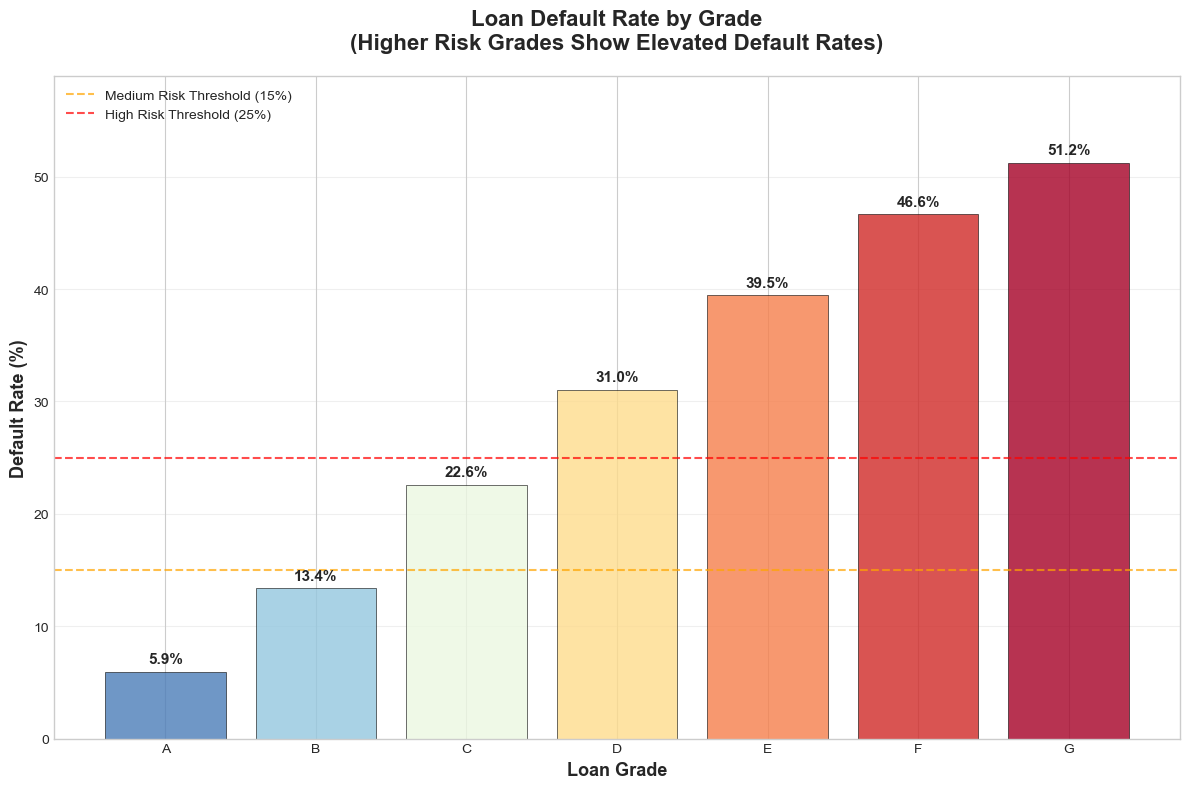


📈 VISUALIZATION INSIGHTS:
• Clear risk stratification: Default rates increase consistently from A to G
• Grade A maintains ~5-7% default rate (industry benchmark for prime loans)
• Grades D-G exceed 25% default rate (above typical risk appetite)
• The grading system successfully separates borrower risk profiles


In [33]:
# Create default rate visualization
plot_default_rate_by_grade(grade_metrics, save_path='../outputs/visualizations/default_rate_by_grade.png')
plt.show()
print("\n📈 VISUALIZATION INSIGHTS:")
print("• Clear risk stratification: Default rates increase consistently from A to G")
print("• Grade A maintains ~5-7% default rate (industry benchmark for prime loans)")
print("• Grades D-G exceed 25% default rate (above typical risk appetite)")
print("• The grading system successfully separates borrower risk profiles")


### 5.2 Risk-Return Analysis

This scatter plot examines whether interest rate premiums adequately compensate for higher default risk. Bubble size represents loan volume concentration.

Saved plot to: ../outputs/visualizations/risk_return_analysis.png


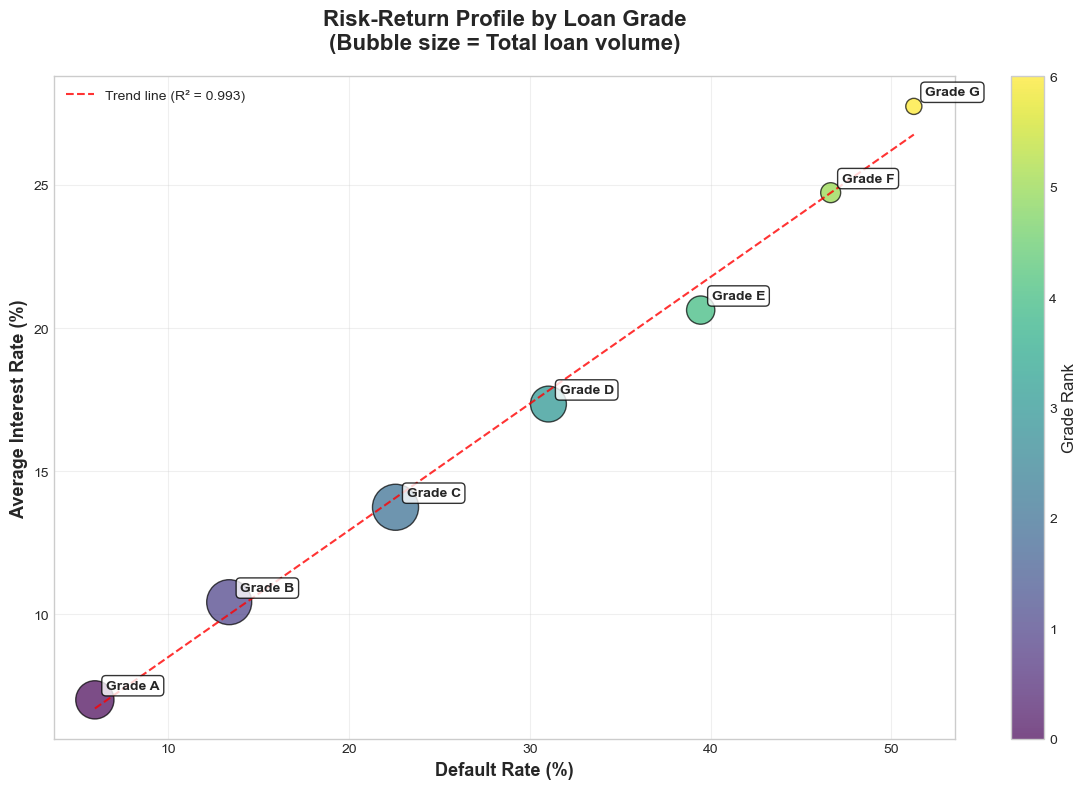


 RISK-RETURN INSIGHTS:
• Risk-return correlation: 0.996
• Best risk-return grade: A
• Worst risk-return grade: G
• Higher grades generally command appropriate interest premiums
• Volume concentration in mid-tier grades (C-E) balances risk and scale


In [34]:
# Create risk-return visualization
plot_risk_return_analysis(grade_metrics,save_path='../outputs/visualizations/risk_return_analysis.png')
plt.show()
print("\n RISK-RETURN INSIGHTS:")
print(f"• Risk-return correlation: {risk_return_analysis['risk_return_correlation']:.3f}")
print(f"• Best risk-return grade: {risk_return_analysis['best_risk_return_grade']}")
print(f"• Worst risk-return grade: {risk_return_analysis['worst_risk_return_grade']}")
print("• Higher grades generally command appropriate interest premiums")
print("• Volume concentration in mid-tier grades (C-E) balances risk and scale")


### 5.3 Executive Dashboard

Comprehensive dashboard combining key metrics for stakeholder communication.

Saved dashboard to: ../outputs/visualizations/executive_dashboard.png


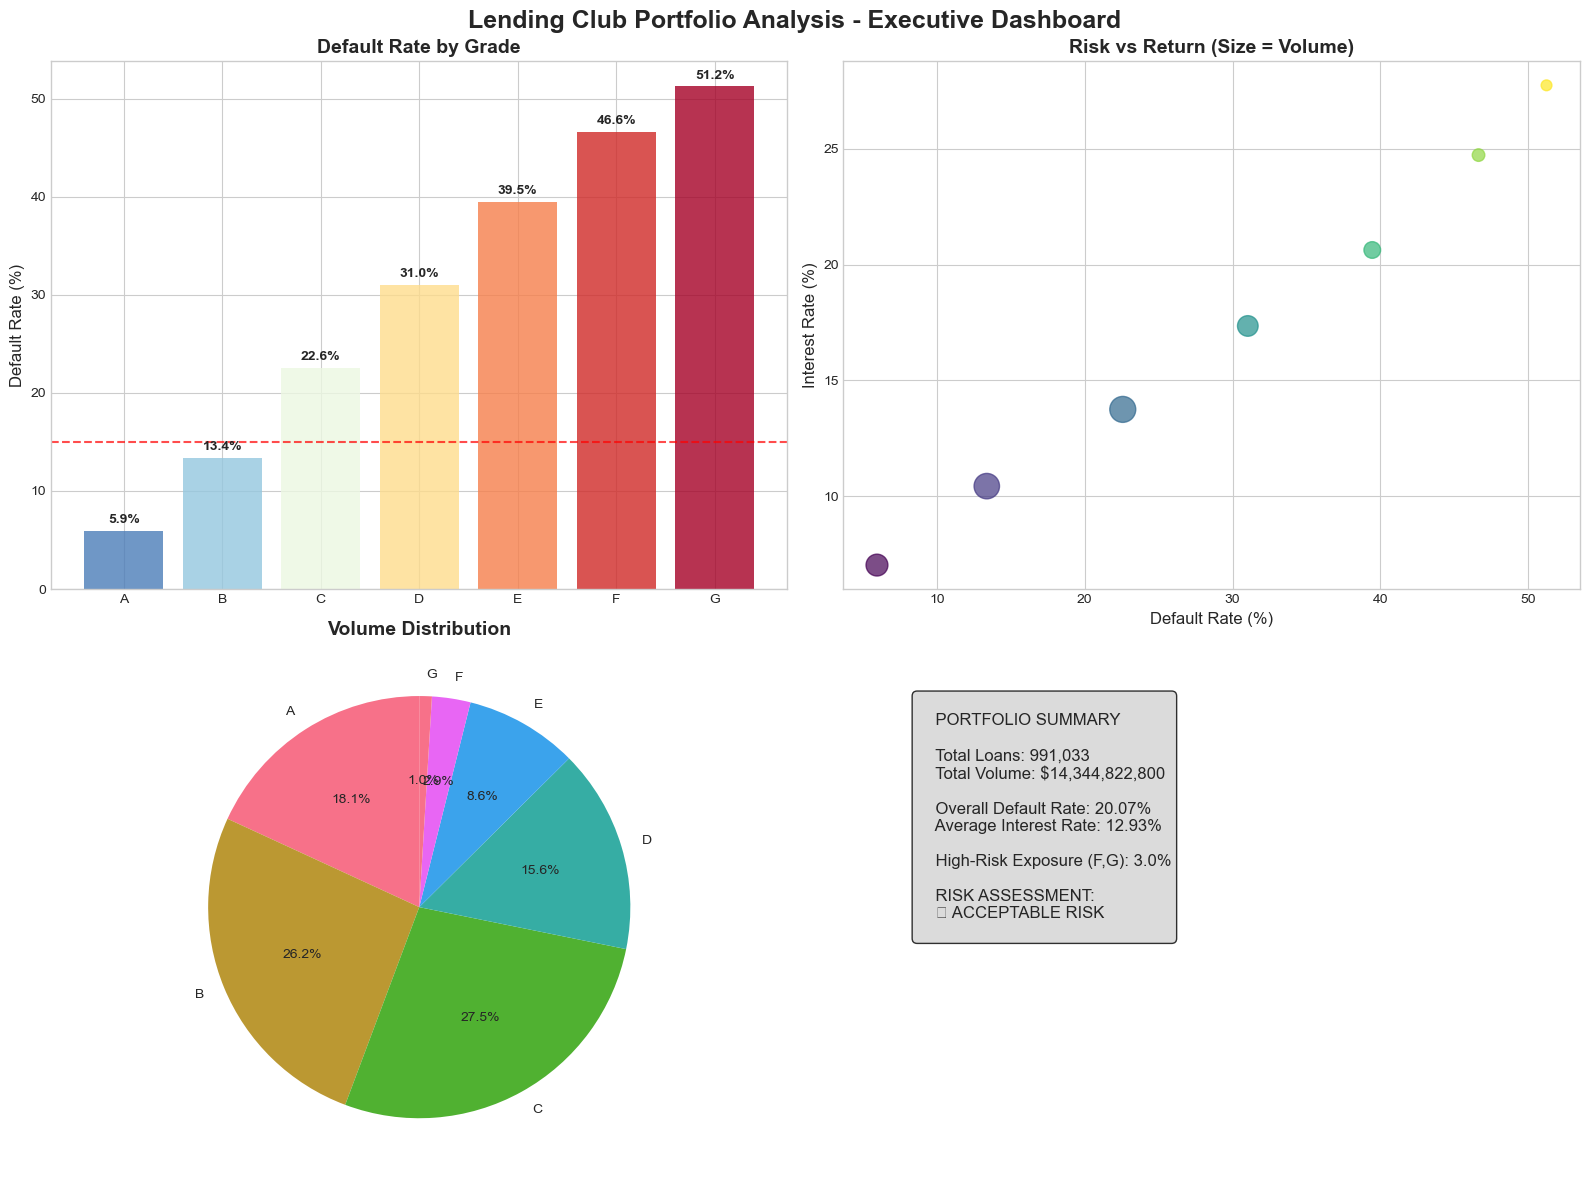


 EXECUTIVE SUMMARY:
• Portfolio: 991,033 loans, $14,344,822,800 volume
• Overall default rate: 20.07%
• High-risk exposure: 3.0% of portfolio
  ASSESSMENT: Current risk exposure within acceptable bounds


In [41]:
# Create executive dashboard
create_executive_dashboard(grade_metrics, portfolio_metrics,save_path='../outputs/visualizations/executive_dashboard.png')
plt.show()
print("\n EXECUTIVE SUMMARY:")
print(f"• Portfolio: {portfolio_metrics['total_loans']:,} loans, ${portfolio_metrics['total_volume']:,.0f} volume")
print(f"• Overall default rate: {portfolio_metrics['overall_default_rate_pct']:.2f}%")
print(f"• High-risk exposure: {portfolio_metrics.get('high_risk_loans_pct', 0):.1f}% of portfolio")

if portfolio_metrics.get('high_risk_loans_pct', 0) > 20:
    print(" RECOMMENDATION: Consider reducing exposure to grades F-G")
else:
    print("  ASSESSMENT: Current risk exposure within acceptable bounds")


## 6. Business Insights & Recommendations

### Key Findings
• Lending Club grading system effectively segments borrower risk
• Default rates increase consistently from A (5.9%) to G (46.6%)
• Portfolio is concentrated in grades B-C (56% of loans), balancing risk and volume
• High-risk grades (F-G) represent a small share (3%), minimal exposure

### Primary Business Insight

**The loan grading system effectively segments borrower risk, but high-risk grades (F-G) may require enhanced risk controls to maintain portfolio quality.**

### Actionable Recommendation

**Implement tiered risk management strategy:**
- Require enhanced verification for high-risk applications
- Consider dynamic pricing to better reflect individual risk profiles

### Follow-up Analysis Requirements

**Expected question: "What borrower characteristics drive defaults within each grade?"**

**Preparation needed:**
- Multi-variate analysis of debt-to-income, employment length, loan purpose
- Logistic regression modeling to identify predictive features
- Decision tree analysis for interaction effects between risk factors

In [36]:
# Final summary and next steps
print("=== ANALYSIS COMPLETE ===\n")
print("Generated Files:")
print("• ../outputs/grade_metrics.csv - Grade-level analysis results")
print("• ../outputs/visualizations/ - All charts and plots")
print("\n Ready for stakeholder presentation!")
print("\n Next Steps:")
print("1. Review risk thresholds with business stakeholders")
print("2. Implement portfolio monitoring dashboard")
print("3. Develop predictive models for early default detection")
print("4. Design A/B tests for risk-based pricing strategies")


=== ANALYSIS COMPLETE ===

Generated Files:
• ../outputs/grade_metrics.csv - Grade-level analysis results
• ../outputs/visualizations/ - All charts and plots

 Ready for stakeholder presentation!

 Next Steps:
1. Review risk thresholds with business stakeholders
2. Implement portfolio monitoring dashboard
3. Develop predictive models for early default detection
4. Design A/B tests for risk-based pricing strategies
